<a href="https://colab.research.google.com/github/HasikaR/Audio-Denoising-Deep-Learning/blob/main/multiple_input_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import copy

In [ ]:
import glob
import zipfile

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth = True)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.per_process_gpu_memory_fraction = 0.34

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
max_length = 1126

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/s6.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/c6.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp2')

In [ ]:
def getData( input_data_path):
 
    speech_list = []
    mag_speech_list = []
    for file in sorted(glob.iglob(input_data_path)):
      s,sr = librosa.load(file , sr=None)
      S = librosa.stft(s, n_fft=1024, hop_length=512)
      stft_len = S.shape[1]
      S = np.pad(S, ((0,0),(0, max_length-stft_len)), 'constant')
      speech_list.append(S)
 
      mag_S = np.abs(S)
      mag_speech_list.append(mag_S)
    
    return speech_list , mag_speech_list

In [ ]:
clean_speech_data_path = '/tmp2/c6/*.wav'
#/content/drive/MyDrive/inputs_clean
clean_speech_list, mag_clean_speech_list = getData( clean_speech_data_path)

In [ ]:
mag_clean_speech_list=np.array(mag_clean_speech_list)

In [ ]:
print(mag_clean_speech_list.shape)

(36, 513, 1126)


In [ ]:
def getData1( input_data_path):
 
    speech_list = []
    mag_speech_list = []
    for file in sorted(glob.iglob(input_data_path)):
      s,sr = librosa.load(file , sr=None)
      X = librosa.stft(s, n_fft=1024, hop_length=512)
      stft_len = X.shape[1]
      X = np.pad(X, ((0,0),(0, max_length-stft_len)), 'constant')
      speech_list.append(X)
 
      mag_X = np.abs(X)
      mag_speech_list.append(mag_X)
    
    return speech_list , mag_speech_list

In [ ]:
mixed_speech_data_path = '/tmp/s6/*.wav'
#/content/drive/MyDrive/inputs
mixed_speech_list, mag_mixed_speech_list = getData1(mixed_speech_data_path)

In [ ]:
mag_mixed_speech_list=np.array(mag_mixed_speech_list)

In [ ]:
print(mag_mixed_speech_list.shape)

(36, 513, 1126)


In [ ]:
mag_mixed_speech_list=mag_mixed_speech_list.reshape(513,36*1126)

In [ ]:
mag_clean_speech_list=mag_clean_speech_list.reshape(513,36*1126)

In [ ]:
x_test, sr = librosa.load('/content/drive/MyDrive/dnn/ss441_cs15_kd21.wav', sr=None)
X_test = librosa.stft(x_test, n_fft=1024, hop_length=512)

x_test2, sr = librosa.load('/content/drive/MyDrive/dnn/ss670_cs23_kd10.wav', sr=None)
X_test2 = librosa.stft(x_test2, n_fft=1024, hop_length=512)

In [ ]:
mag_S = mag_clean_speech_list
mag_X = mag_mixed_speech_list
mag_X_test = np.abs(X_test)
mag_X_test2 = np.abs(X_test2)

#Defining model specifications
learning_rate = 0.0002
num_epochs = 2000
batch_size = 64
window_size = 20

In [ ]:
input = tf.compat.v1.placeholder(tf.float32, [None, 513])
labels = tf.compat.v1.placeholder(tf.float32, [None, 513])

In [ ]:
def getModel(x):
  # Input Layer
  input_layer = tf.reshape(x, [-1, 20, 513, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=16,
      kernel_size=[4,4],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=[2,2])

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[2,2],
      padding="same",
      activation=tf.nn.relu)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=[2,2])

  # Dense Layer
  pool2_flat = tf.layers.flatten(pool2)
  
  logits = tf.layers.dense(inputs=pool2_flat, units=513, activation=tf.nn.relu)
  
  return logits

In [ ]:
def transform_data(x , size , window_size):
  temp = x[0 : 0 + window_size,:]
  for i in range(1 , size - window_size + 1):
      temp_mini = x[i : i + window_size,:]
      temp = np.vstack((temp , temp_mini))
      
  return temp

In [ ]:
#DO NOT RUN THE NEXT 4 LINES AFTER EXECUTING FOR THE 1 ST TIME

In [ ]:
transformed_x = transform_data(mag_X.T , np.shape(mag_X.T)[0] , window_size)

In [ ]:
print(type(transformed_x))

<class 'numpy.ndarray'>


In [ ]:
print(transformed_x.shape)

(810340, 513)


In [ ]:
np.savetxt("/content/drive/MyDrive/transform.txt",transformed_x , delimiter=';', fmt='%s')

In [ ]:
transformed_x=np.loadtxt("/content/drive/MyDrive/transform.txt",delimiter=';')

Execute from this line

In [ ]:
transformed_x1 = copy.deepcopy(transformed_x)


In [ ]:
transformed_x = np.reshape(transformed_x , (40517, 20 , 513))

In [ ]:
transformed_y = (mag_S.T)[window_size - 1 : , :]

In [ ]:
output = getModel(input)
#Defining the loss function along with its optimizer
loss = tf.reduce_mean(tf.square(output - labels))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

count = 0
flag = True
c=[]
l=[]
while flag:
    size = 0
    #Mini batching with the given batch size
    for i in range(0 , 40517, batch_size):
        size += batch_size
        if size <= 40517:
            batch_x = transformed_x[i : size, :]
            batch_y = transformed_y[i : size, :]
        else:
            batch_x = transformed_x[i : 40517, :]
            batch_y = transformed_y[i : 40517, :]
        
        
        batch_x = batch_x.reshape((np.shape(batch_x)[0] * np.shape(batch_x)[1] , np.shape(batch_x)[2]))
        #print(batch_y.shape)
        feed_dict = {input: batch_x, labels: batch_y}
        train_step.run(feed_dict=feed_dict)

    if count%2 == 0:
        loss_calc = loss.eval(feed_dict=feed_dict)
        print("Epoch %d, loss %g"%(count, loss_calc))
        c.append(count)
        l.append(loss_calc)
    
    #Once all the epochs are completed, training is stopped
    if count >= 30:
        flag = False  
        
    count+=1

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Epoch 0, loss 1.18859e-07
Epoch 2, loss 0
Epoch 4, loss 0.0240728
Epoch 6, loss 0.0209792
Epoch 8, loss 0.0135596
Epoch 10, loss 0.00834461
Epoch 12, loss 0.00453327
Epoch 14, loss 0.00199938
Epoch 16, loss 0.00103264
Epoch 18, loss 0.000825532
Epoch 20, loss 0.000626801
Epoch 22, loss 0.000527282
Epoch 24, loss 0.000351725
Epoch 26, loss 0.000401519
Epoch 28, loss 0.000557517
Epoch 30, loss 8.46201e-05


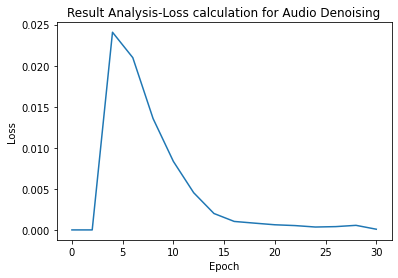

In [ ]:
import matplotlib.pyplot as plt

plt.title("Result Analysis-Loss calculation for Audio Denoising")
      
# label of x-axis
plt.xlabel("Epoch")

plt.ylabel("Loss")

  
# actual ploting
plt.plot(c, l)
  
# shows the plot 
# in new wind

In [ ]:
print(type(output))

<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
print(output.shape)

(?, 513)


In [ ]:
def feedforward(input_data, dnn_output):
    output = dnn_output.eval(feed_dict = {input : input_data})
    
    return output

#Recovering the complex values of the file from the output of the model
def recover_sound(X , mag_X , mag_output):
  temp = X / mag_X
  s_hat = temp * mag_output
  
  return s_hat

#Recovering the lost frames
def recover_data(x , size , value):
  temp = np.full(size , value)
  output = np.vstack((temp , x))
  
  return output

In [ ]:
transformed_x_test = transform_data(mag_X_test.T , np.shape(mag_X_test.T)[0] , window_size)
transformed_x_test2 = transform_data(mag_X_test2.T , np.shape(mag_X_test2.T)[0] , window_size)

In [ ]:
s_hat_test1 = feedforward(transformed_x_test , output)
s_hat_test2 = feedforward(transformed_x_test2 , output)

#Recovering the first 19 frames that were lost
recovered_x_test1 = recover_data(s_hat_test1 , (window_size - 1 , np.shape(s_hat_test1)[1]) , 1e-15)
recovered_x_test2 = recover_data(s_hat_test2 , (window_size - 1 , np.shape(s_hat_test2)[1]) , 1e-15)

#Recovering the complex values of both the test files
s_hat1 = recover_sound(X_test , mag_X_test , recovered_x_test1.T)
s_hat2 = recover_sound(X_test2 , mag_X_test2 , recovered_x_test2.T)

In [ ]:
import soundfile as sf
recon_sound = librosa.istft(s_hat1 , hop_length=512 , win_length=1024)
sf.write('/content/drive/MyDrive/cnn_output/cnn_01.wav', recon_sound,sr)
recon_sound2 = librosa.istft(s_hat2 , hop_length=512 , win_length=1024)
sf.write('/content/drive/MyDrive/cnn_output/cnn_02.wav', recon_sound2,sr)

In [ ]:
s_hat_test3 = feedforward(transformed_x1 , output)
recovered_x1 = recover_data(s_hat_test3 , (window_size - 1 , np.shape(s_hat_test3)[1]) , 1e-15)
s_hat3 = recover_sound(X, mag_X , recovered_x1.T)
recon_sound3 = librosa.istft(s_hat3 , hop_length=512 , win_length=1024)
size_recon_sound3 = np.shape(recon_sound3)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
